In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/silk-dataset/silk_dataset/IMG_3946.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2771.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3912.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3167.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2760.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2844.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2765.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2711.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3114.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2740.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3538.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2791.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3095.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3520.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2987.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3809.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3030.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3925.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_27

Starting Watershed segmentation on example images...
Processing: IMG_2679.jpg


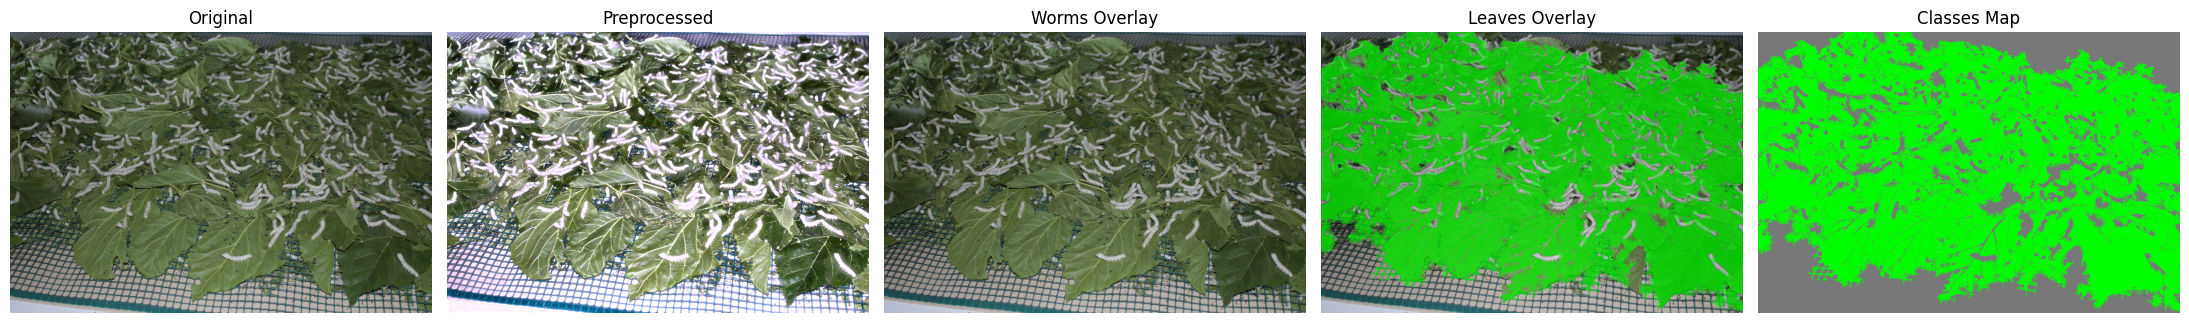

Processing: IMG_2703.jpg


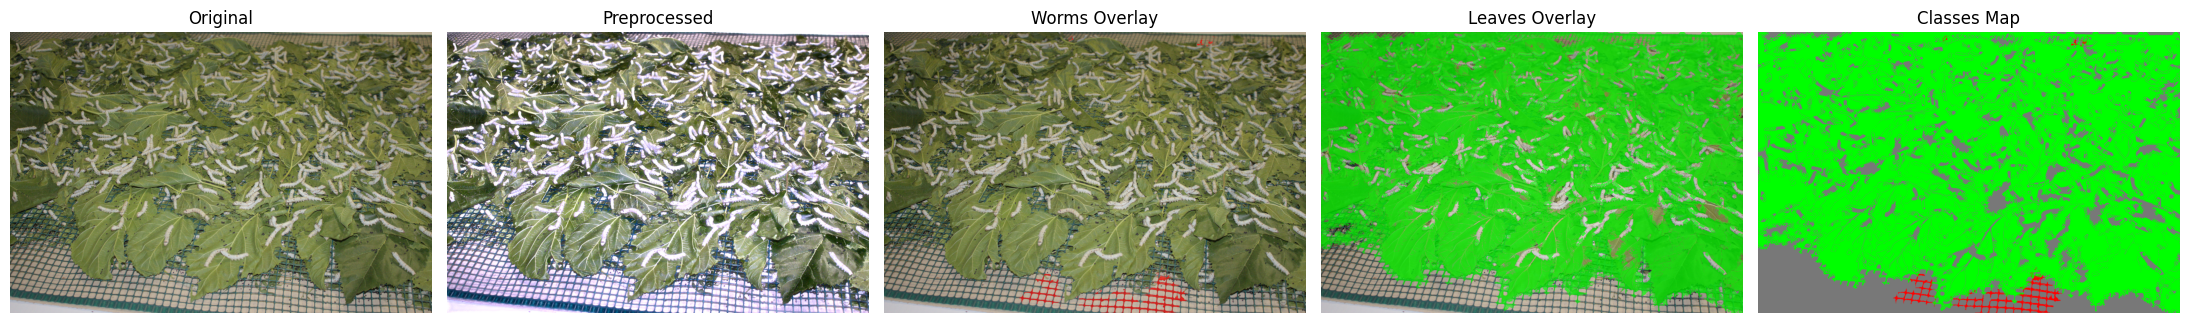

Example segmentation completed.

Generating and saving all Watershed masks (1351 images)...
Processed 1351/1351
All Watershed masks saved.


In [4]:
import cv2
from typing import Tuple 
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random # Added for random image selection

# --- START PREPROCESSING AND UTILITY FUNCTIONS FROM YOUR PREVIOUS CODE ---
# These functions are necessary for the example to work.

GAMMA = 2.2 # Gamma value for sRGB to linear conversion. Standard for sRGB.
inverse_gamma = 1.0 / GAMMA # Pre-calculate inverse gamma for linear to sRGB conversion.

def sRGB_to_linear(image_srgb: np.ndarray) -> np.ndarray:
    """
    Converts an sRGB image (0-255 uint8) to linear RGB space (0.0-1.0 float32).
    Applies a power function based on GAMMA.
    """
    srgb_norm = image_srgb.astype(np.float32) / 255.0 # Normalize pixel values to 0.0-1.0.
    return np.power(srgb_norm, GAMMA) # Apply gamma correction.

def linear_to_sRGB(image_linear: np.ndarray) -> np.ndarray:
    """
    Converts a linear RGB image (0.0-1.0 float32) back to sRGB space (0-255 uint8).
    Applies inverse gamma and clips values.
    """
    clipped = np.clip(image_linear, 0.0, 1.0) # Clip values to ensure they are within the valid range [0.0, 1.0].
    srgb_norm = np.power(clipped, inverse_gamma) # Apply inverse gamma correction.
    return (srgb_norm * 255).astype(np.uint8) # Scale back to 0-255 and convert to uint8.

def normalize_image_brightness(image_srgb: np.ndarray, target_luma: float = 0.35) -> np.ndarray:
    """
    Normalizes the brightness of an sRGB image to a target mean luminance.
    Operates in linear light space.
    """
    linear = sRGB_to_linear(image_srgb) # Convert sRGB to linear RGB.
    # Calculate luminance using standard coefficients.
    luma = 0.2126 * linear[..., 0] + 0.7152 * linear[..., 1] + 0.0722 * linear[..., 2]
    scale = target_luma / (luma.mean() + 1e-6) # Calculate scaling factor based on mean luminance. Add epsilon to avoid division by zero.
    linear_scaled = np.clip(linear * scale, 0.0, 1.0) # Apply scale and clip to valid range.
    return linear_to_sRGB(linear_scaled) # Convert back to sRGB.

def apply_gray_world_balance(image_srgb: np.ndarray) -> np.ndarray:
    """
    Applies Gray World color balance to an sRGB image.
    Assumes the average color of a scene is neutral gray.
    """
    img32 = image_srgb.astype(np.float32) # Convert to float32 for calculations.
    avg_channels = img32.mean(axis=(0,1)) # Calculate mean intensity for each channel (R, G, B).
    overall_mean = avg_channels.mean() # Calculate the overall average intensity across all channels.
    scales = overall_mean / (avg_channels + 1e-6) # Calculate scaling factors for each channel.
    balanced = img32 * scales # Apply scaling to balance colors.
    return np.clip(balanced, 0, 255).astype(np.uint8) # Clip and convert back to uint8.

FOURIER_HIGH_PASS_RADIUS = 30 # Radius for the high-pass filter in the frequency domain.

def high_pass_filter(image_gray: np.ndarray, radius: int = FOURIER_HIGH_PASS_RADIUS) -> np.ndarray:
    """
    Applies a circular high-pass filter in the Fourier domain to a grayscale image.
    This enhances edges and fine details.
    """
    h, w = image_gray.shape # Get image dimensions.
    cy, cx = h // 2, w // 2 # Calculate the center of the image.
    dft = cv2.dft(image_gray.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT) # Compute 2D Discrete Fourier Transform.
    dft_shifted = np.fft.fftshift(dft) # Shift the zero-frequency component to the center.

    mask = np.ones((h, w, 2), np.uint8) # Create a mask of ones (for both real and imaginary parts).
    # Create a circular region of zeros at the center (low frequencies).
    # This acts as the high-pass filter (passing high frequencies, blocking low).
    cv2.circle(mask, (cx, cy), radius, 0, -1) 
    
    fshift = dft_shifted * mask # Apply the mask to the shifted DFT.
    f_ishift = np.fft.ifftshift(fshift) # Shift the zero-frequency component back.
    back = cv2.idft(f_ishift) # Compute the Inverse Discrete Fourier Transform.
    magnitude = cv2.magnitude(back[..., 0], back[..., 1]) # Calculate the magnitude of the complex result.
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) # Normalize to 0-255 and convert to uint8.

CLAHE_CLIP = 2.0 # Clipping limit for CLAHE (Contrast Limited Adaptive Histogram Equalization).
CLAHE_GRID = (8, 8) # Grid size for CLAHE.
GREEN_BOOST = 1.5 # Factor to boost green saturation.

def preprocess_image(image_rgb: np.ndarray) -> np.ndarray:
    """
    Applies a series of image preprocessing steps including brightness normalization,
    color balancing, contrast enhancement (CLAHE), high-pass filtering, and green channel boosting.
    """
    normed = normalize_image_brightness(image_rgb) # Normalize brightness.
    balanced = apply_gray_world_balance(normed) # Apply Gray World color balance.
    lab = cv2.cvtColor(balanced, cv2.COLOR_RGB2LAB) # Convert to LAB color space.
    L, A, B = cv2.split(lab) # Split LAB channels.
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID) # Create CLAHE object.
    L_eq = clahe.apply(L) # Apply CLAHE to the Luminance (L) channel.
    contrast = cv2.cvtColor(cv2.merge((L_eq, A, B)), cv2.COLOR_LAB2RGB) # Merge channels back and convert to RGB.
    gray = cv2.cvtColor(contrast, cv2.COLOR_RGB2GRAY) # Convert to grayscale for high-pass filter.
    hp_mask = high_pass_filter(gray) # Apply high-pass filter.
    # Blend the high-pass filtered result back with the contrast-enhanced image.
    boosted = cv2.addWeighted(contrast, 1.0, cv2.cvtColor(hp_mask, cv2.COLOR_GRAY2RGB), 0.5, 0)
    hsv = cv2.cvtColor(boosted, cv2.COLOR_RGB2HSV).astype(np.float32) # Convert to HSV for green boost.
    H, S, V = cv2.split(hsv) # Split HSV channels.
    green_zone = (H >= 35) & (H <= 100) & (S >= 40) # Define a "green zone" based on hue and saturation.
    S[green_zone] *= GREEN_BOOST # Boost saturation in the green zone.
    hsv[..., 1] = np.clip(S, 0, 255) # Clip saturation values and assign back.
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB) # Convert back to RGB.

MIN_COMPONENT_AREA = 300 # Minimum area in pixels for a connected component to be considered valid.

def filter_small_components(binary_mask: np.ndarray, min_size: int = MIN_COMPONENT_AREA) -> np.ndarray:
    """
    Filters out small connected components (blobs) from a binary mask.
    This helps remove noise and isolated pixels.
    """
    # Find connected components and their statistics.
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        binary_mask.astype(np.uint8), connectivity=8 # 8-connectivity (includes diagonals).
    )
    clean_mask = np.zeros_like(binary_mask, dtype=np.uint8) # Initialize an empty mask.
    # Iterate through each component (excluding background, label 0).
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_size: # Check if component area meets minimum size.
            clean_mask[labels == label] = 1 # Keep components that are large enough.
    return clean_mask # Return the mask with small components removed.

def expand_leaves(preprocessed_rgb: np.ndarray, leaf_mask: np.ndarray, iterations: int = 15) -> np.ndarray:
    """
    Expands the leaf mask outwards, avoiding strong edges from the image.
    This helps in capturing the full extent of leaves, especially those with subtle boundaries.
    """
    gray = cv2.cvtColor(preprocessed_rgb, cv2.COLOR_RGB2GRAY) # Convert preprocessed image to grayscale.
    edges = cv2.Canny(gray, 40, 100) # Apply Canny edge detection.
    edge_block = edges > 0 # Create a boolean mask where edges are present.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)) # Define a small elliptical structuring element for dilation.
    expanded = leaf_mask.copy().astype(np.uint8) # Start expansion from the initial leaf mask.

    for _ in range(iterations): # Iterate multiple times for gradual expansion.
        dilated = cv2.dilate(expanded, kernel) # Dilate the current expanded mask.
        growth = dilated & (~edge_block) # Identify new areas for growth that are NOT strong edges.
        expanded = np.clip(expanded | growth, 0, 1) # Add new growth to the expanded mask and clip.
    
    # After expansion, filter out any small artifacts that might have been created.
    expanded = filter_small_components(expanded, min_size=MIN_COMPONENT_AREA)
    return expanded

# --- END PREPROCESSING AND UTILITY FUNCTIONS FROM THE PREVIOUS CODE ---


def watershed_segmentation(image_rgb: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Performs Watershed segmentation on an input RGB image to segment 'worm' and 'leaf' regions.
    It uses a series of image processing steps to prepare the image, extract markers,
    and classify segments based on color properties.

    Args:
        image_rgb (np.ndarray): The input image in RGB format (NumPy array).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing two binary masks:
                                       - worm_mask: Binary mask for worm regions (1 for worm, 0 for not worm).
                                       - leaf_mask: Binary mask for leaf regions (1 for leaf, 0 for not leaf).
    """
    # 1. Preprocessing the image to enhance boundaries and colors
    prepped_img = preprocess_image(image_rgb)
    gray_prepped = cv2.cvtColor(prepped_img, cv2.COLOR_RGB2GRAY)
    
    # 2. Adaptive Thresholding to get an initial binary mask (likely foreground/background).
    # THRESH_OTSU automatically determines the optimal threshold value.
    _, sure_fg = cv2.threshold(gray_prepped, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 3. Finding "sure background" region
    # Dilate the inverted binary mask to get a region that is definitely background.
    kernel = np.ones((3,3), np.uint8) # Small kernel for morphological operations.
    sure_bg = cv2.dilate(sure_fg, kernel, iterations=3)

    # 4. Finding "sure foreground" region
    # Erode the initial binary mask to get a region that is definitely foreground.
    sure_fg = cv2.erode(sure_fg, kernel, iterations=3)
    
    # 5. Finding the "unknown" region
    # The unknown region is the area between sure foreground and sure background.
    unknown = cv2.subtract(sure_bg, sure_fg)

    # 6. Creating markers for the Watershed algorithm
    # Apply connected components to the sure foreground to get initial markers for distinct objects.
    num_labels, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1 # Increment all markers by 1 (OpenCV Watershed expects background as 1).
    markers[unknown == 255] = 0 # Mark the unknown region as 0 (for Watershed).

    # 7. Apply the Watershed algorithm
    # The Watershed algorithm takes the preprocessed image and the markers,
    # and segments the image based on these "seeds".
    markers = cv2.watershed(prepped_img, markers)

    # 8. Post-processing Watershed results and classification into worm/leaf masks.
    worm_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8) # Initialize empty mask for worms.
    leaf_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8) # Initialize empty mask for leaves.

    # Iterate over each region segmented by Watershed (skipping background and unknown regions).
    # Watershed outputs labels from 1 to num_labels for segmented objects.
    # Marker 0 is for the unknown region, Marker 1 is for the dilated background.
    # So, actual object regions start from label 2.
    for label in range(2, num_labels + 1):
        region_mask = (markers == label).astype(np.uint8) * 255 # Create a binary mask for the current region.
        
        if np.sum(region_mask) == 0: continue # Skip if the region mask is empty.

        # Calculate the average color properties of the current region on the ORIGINAL image.
        # This is important for accurate color-based classification.
        mean_color_bgr = cv2.mean(image_rgb, mask=region_mask)
        mean_b, mean_g, mean_r = mean_color_bgr[0], mean_color_bgr[1], mean_color_bgr[2]
        
        # --- IMPROVED CLASSIFICATION LOGIC FOR WORMS AND LEAVES ---
        # Based on parameters used in previous U2-Net post-classification code for robustness.
        # Convert mean color to other color spaces for better discrimination.
        mean_rgb_linear = sRGB_to_linear(np.array([[mean_r, mean_g, mean_b]], dtype=np.uint8))[0]
        mean_luminance = 0.2126 * mean_rgb_linear[0] + 0.7152 * mean_rgb_linear[1] + 0.0722 * mean_rgb_linear[2]

        mean_hsv = cv2.cvtColor(np.array([[[mean_r, mean_g, mean_b]]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0,0]
        mean_h, mean_s, mean_v = mean_hsv[0], mean_hsv[1], mean_hsv[2]

        mean_lab = cv2.cvtColor(np.array([[[mean_r, mean_g, mean_b]]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0,0]
        mean_l_lab, mean_a_lab, mean_b_lab = mean_lab[0], mean_lab[1], mean_lab[2]
        
        is_leaf = False
        is_worm = False

        # Rules for Leaves (more robust criteria)
        # Excess Green (ExG) index: sensitive to green color.
        exg = 2 * mean_g - mean_r - mean_b
        # CIELAB a* channel: negative values indicate green/blue hues, lower values are greener.
        # Luminance (L_lab) within a certain range.
        if (exg > 20 and # Higher threshold for ExG for stronger green indication.
            mean_a_lab < 120 and # a* < 128 (center) indicates green/blue. Lower values are greener.
            mean_l_lab > 30 and mean_l_lab < 200): # LAB Luminosity range.
            is_leaf = True
            
        # Rules for Worms (based on color neutrality, brightness, HSV properties)
        # Worms tend to be less saturated with more "neutral" colors (grayish, light brown)
        # and a specific luminosity range.
        
        # Ratio between max and min RGB channels (for color neutrality, close to 1 for neutral colors).
        max_rgb = max(mean_r, mean_g, mean_b)
        min_rgb = min(mean_r, mean_g, mean_b)
        color_spread_ratio = max_rgb / (min_rgb + 1e-6) # Avoid division by zero.
        
        # Conditions for worms:
        if (color_spread_ratio < 1.5 and # Relatively neutral color (e.g., gray, light brown).
            mean_s < 80 and # Low HSV saturation.
            mean_v > 100 and # HSV brightness (not too dark).
            mean_luminance > 0.15): # Linear luminance.
            is_worm = True

        # Prioritization: If a region satisfies both leaf and worm conditions, prioritize leaf.
        # (Assuming leaves are typically larger and more dominant in the scene).
        if is_leaf:
            leaf_mask[markers == label] = 1 # Assign to leaf mask.
        elif is_worm:
            worm_mask[markers == label] = 1 # Assign to worm mask.

    # Final cleanup (optional, but recommended for Watershed to remove small artifacts).
    worm_mask = filter_small_components(worm_mask)
    leaf_mask = filter_small_components(leaf_mask)
    
    # Apply leaf prioritization and expansion as in your previous script for robustness.
    # Leaves take precedence over worms.
    worm_mask[leaf_mask == 1] = 0 # Any worm pixels overlapping with leaves are re-assigned to leaves.
    leaf_mask = expand_leaves(prepped_img, leaf_mask) # Expand leaf regions to better capture full extent.
    worm_mask[leaf_mask == 1] = 0 # Re-apply priority after leaf expansion.

    return worm_mask, leaf_mask # Return the final worm and leaf masks.

# Function to visualize the segmentation results 
def display_segmentation(original: np.ndarray, preprocessed: np.ndarray, worm_mask: np.ndarray, leaf_mask: np.ndarray):
    """
    Displays the original image, preprocessed image, and segmentation masks
    (worms, leaves, and a combined class map) in a single plot.

    Args:
        original (np.ndarray): The original RGB image.
        preprocessed (np.ndarray): The preprocessed RGB image.
        worm_mask (np.ndarray): Binary mask for worms (1 for worm, 0 otherwise).
        leaf_mask (np.ndarray): Binary mask for leaves (1 for leaf, 0 otherwise).
    """
    # Create overlay images by blending masks with the original image.
    red_overlay = original.copy()
    green_overlay = original.copy()
    
    # Apply red overlay for worms (70% mask, 30% original).
    red_overlay[worm_mask == 1] = (
        red_overlay[worm_mask == 1] * 0.3 + np.array([255, 0, 0]) * 0.7
    ).astype(np.uint8)
    
    # Apply green overlay for leaves (70% mask, 30% original).
    green_overlay[leaf_mask == 1] = (
        green_overlay[leaf_mask == 1] * 0.3 + np.array([0, 255, 0]) * 0.7
    ).astype(np.uint8)
    
    # Create a combined class map (grey for background, green for leaves, red for worms).
    h, w, _ = original.shape
    class_map = np.full((h, w, 3), 120, dtype=np.uint8) # Initialize with grey background.
    class_map[leaf_mask == 1] = [0, 255, 0] # Set leaf regions to green.
    class_map[worm_mask == 1] = [255, 0, 0] # Set worm regions to red.

    # Prepare panels and titles for plotting.
    panels = [original, preprocessed, red_overlay, green_overlay, class_map]
    titles = ["Original", "Preprocessed", "Worms Overlay", "Leaves Overlay", "Classes Map"]

    # Create a figure with subplots and display images.
    fig, axes = plt.subplots(1, 5, figsize=(22, 4)) # 1 row, 5 columns.
    for ax, img, title in zip(axes, panels, titles):
        ax.imshow(img) # Display the image.
        ax.set_title(title) # Set subplot title.
        ax.axis("off") # Turn off axis labels and ticks.
    plt.tight_layout() # Adjust subplot parameters for a tight layout.
    plt.show() # Display the plot.

# --- Example Usage ---
IMAGE_DIR = '/kaggle/input/silk-dataset/silk_dataset' # Ensure this directory exists and contains images.
NUM_SAMPLES = 2 # Process only 2 images for the example demonstration.

# Check if the image directory exists and contains files.
if not os.path.exists(IMAGE_DIR):
    print(f"The directory {IMAGE_DIR} does not exist. Please create it and place some images inside.")
else:
    # Get a list of image files (jpg, jpeg, png) from the directory.
    files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not files:
        print(f"No images found in the directory {IMAGE_DIR}.")
    else:
        random.shuffle(files) # Shuffle the list to pick random samples.
        files_to_process = files[:NUM_SAMPLES] # Select a subset for processing.

        print("Starting Watershed segmentation on example images...")
        for img_name in files_to_process:
            print(f"Processing: {img_name}")
            bgr_img = cv2.imread(os.path.join(IMAGE_DIR, img_name)) # Load image in BGR format.
            if bgr_img is None:
                print(f"Skipped {img_name}: couldn't load") # Skip if image loading fails.
                continue

            rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB.
            prepped = preprocess_image(rgb_img) # Get the pre-processed image.
            
            # Apply Watershed segmentation to the original RGB image.
            worms_mask, leaves_mask = watershed_segmentation(rgb_img)
            
            # Display the segmentation results.
            display_segmentation(rgb_img, prepped, worms_mask, leaves_mask)
        print("Example segmentation completed.")

# --- Part for Processing and Saving All Watershed Masks ---
OUTPUT_WATERSHED_MASKS = "/kaggle/working/watershed_masked" # Directory to save all generated Watershed masks.
os.makedirs(OUTPUT_WATERSHED_MASKS, exist_ok=True) # Create the output directory.

all_imgs = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))] # List all images.
current = 0 # Counter for processed images.
total = len(all_imgs) # Total number of images to process.

print(f"\nGenerating and saving all Watershed masks ({total} images)...")
for fname in all_imgs:
    bgr = cv2.imread(os.path.join(IMAGE_DIR, fname)) # Load image in BGR format.
    if bgr is None:
        print(f"skip {fname} (cannot read)")
        continue

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) # Convert to RGB.
    
    # Generate worm and leaf masks using Watershed segmentation.
    worms, leaves = watershed_segmentation(rgb)

    # Construct the 3-class mask (grey background, green for leaves, red for worms).
    h, w = rgb.shape[:2]
    mask_rgb = np.full((h, w, 3), 120, dtype=np.uint8) # Initialize with grey background.
    mask_rgb[leaves == 1] = [0, 255, 0] # Set leaf pixels to green.
    mask_rgb[worms == 1] = [255, 0, 0] # Set worm pixels to red.

    # Define the output path for the Watershed mask (e.g., "image_name_watershed_mask.png").
    out_m = os.path.join(OUTPUT_WATERSHED_MASKS, os.path.splitext(fname)[0] + "_watershed_mask.png")
    # Save the mask. Convert back to BGR before saving as OpenCV's imwrite expects BGR.
    cv2.imwrite(out_m, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))
    
    current += 1
    # Print progress on the same line.
    print(f"\rProcessed {current}/{total}", end="", flush=True)

print("\nAll Watershed masks saved.")

In [5]:
import os
import zipfile


WATERSHED_MASKS_DIR = "/kaggle/working/watershed_masked"

WATERSHED_ZIP_FILE_PATH = '/kaggle/working/watershed_masked.zip'

print(f"Zipping the folder: {WATERSHED_MASKS_DIR} in {WATERSHED_ZIP_FILE_PATH}...")

!zip -r {WATERSHED_ZIP_FILE_PATH} {WATERSHED_MASKS_DIR}

print("Complete!")
print(f"File ZIP '{WATERSHED_ZIP_FILE_PATH}' created.")

Zipping the folder: /kaggle/working/watershed_masked in /kaggle/working/watershed_masked.zip...
  adding: kaggle/working/watershed_masked/ (stored 0%)
  adding: kaggle/working/watershed_masked/IMG_3972_watershed_mask.png (deflated 33%)
  adding: kaggle/working/watershed_masked/IMG_2994_watershed_mask.png (deflated 37%)
  adding: kaggle/working/watershed_masked/IMG_3007_watershed_mask.png (deflated 36%)
  adding: kaggle/working/watershed_masked/IMG_3992_watershed_mask.png (deflated 33%)
  adding: kaggle/working/watershed_masked/IMG_3936_watershed_mask.png (deflated 38%)
  adding: kaggle/working/watershed_masked/IMG_3540_watershed_mask.png (deflated 41%)
  adding: kaggle/working/watershed_masked/IMG_2729_watershed_mask.png (deflated 41%)
  adding: kaggle/working/watershed_masked/IMG_3526_watershed_mask.png (deflated 30%)
  adding: kaggle/working/watershed_masked/IMG_3159_watershed_mask.png (deflated 39%)
  adding: kaggle/working/watershed_masked/IMG_3710_watershed_mask.png (deflated 38%)